## Modules

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,SimpleRNN
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import GRU, Dense
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import tensorflow as tf
from tensorflow.keras.layers import Dropout
import optuna


from time import time_ns
import random
import keras

SEED = 10

random.seed(SEED)
np.random.seed(SEED)
keras.utils.set_random_seed(SEED)

In [2]:
print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Tensorflow Version: 2.10.1
Num GPUs: 1


## Funções Uteis

In [3]:
def plot_list(input_list, figsize=(20, 6)):
    """
    Plot a given list.

    Parameters:
        input_list (list): The list of data points to be plotted.

    Returns:
        None: The function displays the plot.
    """
    # Generate x values as indices of the list elements
    x = range(len(input_list))

    # Set the figure size
    plt.figure(figsize=figsize)

    # Plot the data
    plt.plot(x, input_list)

    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('BORE_OIL_VOL')
    plt.title('Plot of the BORE_OIL_VOL')

    # Display the plot
    plt.show()

In [4]:
def plot_train_test_data(train, test, split_index):
    """
    Plot the train and test data with a red dashed line indicating the split_index.

    Parameters:
        train (list): The train data to be plotted.
        test (list): The test data to be plotted.
        split_index (int): The index where the data is split between train and test.

    Returns:
        None
    """
    plt.figure(figsize=(20, 6))
    plt.plot(range(len(train)), train, 'k-', label='Train Data')  # Black line for Train
    plt.plot(range(len(train), len(train) + len(test)), test, 'b-', label='Test Data')  # Blue line for Test
    plt.axvline(x=split_index - 0.5, color='r', linestyle='--', label='Split Index')  # Red dashed line at split_index

    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Train and Test Data')
    plt.legend()

    # Show the plot
    plt.show()

In [5]:
def scale_train_test_data(train, test, scaling_type='minmax'):
    """
    Scale the train and test data using the specified scaling method.

    Parameters:
        train (list or numpy array): The train data to be used for fitting the scaler.
        test (list or numpy array): The test data to be transformed using the fitted scaler.
        scaling_type (str, optional): The type of scaling method. Possible values are 'standard',
                                      'minmax' (default), and 'robust'.

    Returns:
        tuple: A tuple containing the transformed train and test data.
    """
    # Convert train and test data to numpy arrays if they are not already
    if not isinstance(train, np.ndarray):
        train = np.array(train)
    if not isinstance(test, np.ndarray):
        test = np.array(test)

    # Initialize the scaler based on the specified scaling_type
    if scaling_type == 'standard':
        scaler = StandardScaler()
    elif scaling_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaling_type == 'robust':
        scaler = RobustScaler()
    else:
        raise ValueError("Invalid scaling_type. Supported values are 'standard', 'minmax', or 'robust'.")

    # Fit the scaler to the train data
    scaler.fit(train.reshape(-1, 1))  # Reshape to a single feature for fitting

    # Transform train and test data using the fitted scaler
    train_scaled = scaler.transform(train.reshape(-1, 1)).flatten()
    test_scaled = scaler.transform(test.reshape(-1, 1)).flatten()

    return train_scaled, test_scaled

In [6]:
def prepare_rnn_data(scaled_data, window_size, num_outputs=1):
    """
    Prepare the scaled data for an RNN model.

    Parameters:
        scaled_data (numpy array): The scaled data to be prepared.
        window_size (int): The number of time steps to consider as input for the RNN.
        num_outputs (int, optional): The number of output time steps for prediction (default=1).

    Returns:
        tuple: A tuple containing the input sequences and corresponding output sequences.
    """
    data_size = len(scaled_data)

    # Create empty lists to store input and output sequences
    input_sequences = []
    output_sequences = []

    # Generate input and output sequences
    for i in range(data_size - window_size - num_outputs + 1):
        input_seq = scaled_data[i : i + window_size]
        output_seq = scaled_data[i + window_size : i + window_size + num_outputs]
        input_sequences.append(input_seq)
        output_sequences.append(output_seq)

    # Convert the lists to numpy arrays for RNN input
    input_sequences = np.array(input_sequences)
    output_sequences = np.array(output_sequences)

    return input_sequences, output_sequences

In [7]:
def prepare_rnn_data(scaled_data, window_size, num_outputs=1):
    """
    Prepare a list as a dataset for training an RNN.

    Parameters:
        input_list (list): The list of data points.
        window_size (int): The number of time steps in each window for prediction.
        train_ratio (float, optional): The ratio of training data to the entire dataset. Default is 0.8.
        scaling (str, optional): The scaling method. Options: None (no scaling), "minmax" (Min-Max Scaling),
                                 "standard" (Standardization). Default is None.

    Returns:
        tuple: A tuple containing the train and test datasets in the format (X_train, y_train, X_test, y_test).
              X_train (numpy.ndarray): Training features (input sequences).
              y_train (numpy.ndarray): Training labels (output values to be predicted).
              X_test (numpy.ndarray): Testing features (input sequences).
              y_test (numpy.ndarray): Testing labels (output values to be predicted).
    """
    # Create windows for the RNN
    windows = []
    num_windows = len(scaled_data) - window_size + 1

    for i in range(num_windows):
        window = scaled_data[i:i + window_size]
        windows.append(window)

    # Convert the list of windows to a numpy array
    scaled_data = np.array(windows)

    # Split the dataset into train and test sets
    split_index = int(len(scaled_data) * train_ratio)
    X, y = scaled_data[:split_index, :-1], scaled_data[:split_index, -1]


    return X,y

In [8]:
def plot_result_graphs(train_loss_history, y_train, y_train_pred, y_test, y_test_pred):
        plt.figure(figsize=(14, 10))

        # Plot Train and Test Loss
        plt.subplot(2, 2, 1)
        plt.plot(train_loss_history, label='Train Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Train and Test Loss')
        plt.legend()

        # Plot Train Data and Train Prediction
        plt.subplot(2, 2, 2)
        plt.plot(y_train, label='Train Data', marker='o')
        plt.plot(y_train_pred, label='Train Prediction', marker='x')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Train Data and Train Prediction')
        plt.legend()

        # Plot Test Data and Test Prediction
        plt.subplot(2, 2, 3)
        plt.plot(y_test, label='Test Data', marker='o')
        plt.plot(y_test_pred, label='Test Prediction', marker='x')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Test Data and Test Prediction')
        plt.legend()

        plt.tight_layout()
        plt.show()

## Carregar a Base de dados do Drive

In [9]:
###########################################################
file_name = r"C:\Users\vinicius\Documents\Repositorios\TimeSeriesPredictionFinalProject\src\data\Base_Volve_Pocos.xlsx" # File name
###########################################################

#MELHOR PARA TREINAR E FICAR BOM: 'NO15-9-F-1-C'>'NO15-9-F-15-D' -> Esse cara vai muito para zero
# BOM MAS COM PERFIL SHIFITADO 'NO15-9-F-11-H'~=~'NO15-9-F-12-H'#
sheet_name ='NO15-9-F-1-C' #'NO15-9-F-12-H'# 'NO15-9-F-14-H'#'NO15-9-F-15-D'#'NO15-9-F-11-H'#'NO15-9-F-12-H'#'NO15-9-F-11-H'# 4th sheet
header = 0 # The header is the 2nd row
df_full = pd.read_excel(file_name, sheet_name = sheet_name, header = header)
df_full.head()

,DATEPRD,WELL_BORE_CODE,NPD_WELL_BORE_CODE,NPD_WELL_BORE_NAME,NPD_FIELD_CODE,NPD_FIELD_NAME,NPD_FACILITY_CODE,NPD_FACILITY_NAME,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,...,AVG_CHOKE_UOM,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,FLOW_KIND,WELL_TYPE
0,2014-04-07,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,0.00000,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,WI
1,2014-04-08,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
2,2014-04-09,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
3,2014-04-10,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
4,2014-04-11,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,310.37614,...,%,33.09788,10.47992,33.07195,0.0,0.0,0.0,NaN,production,OP


## Pre processamento

<class 'pandas.core.series.Series'>


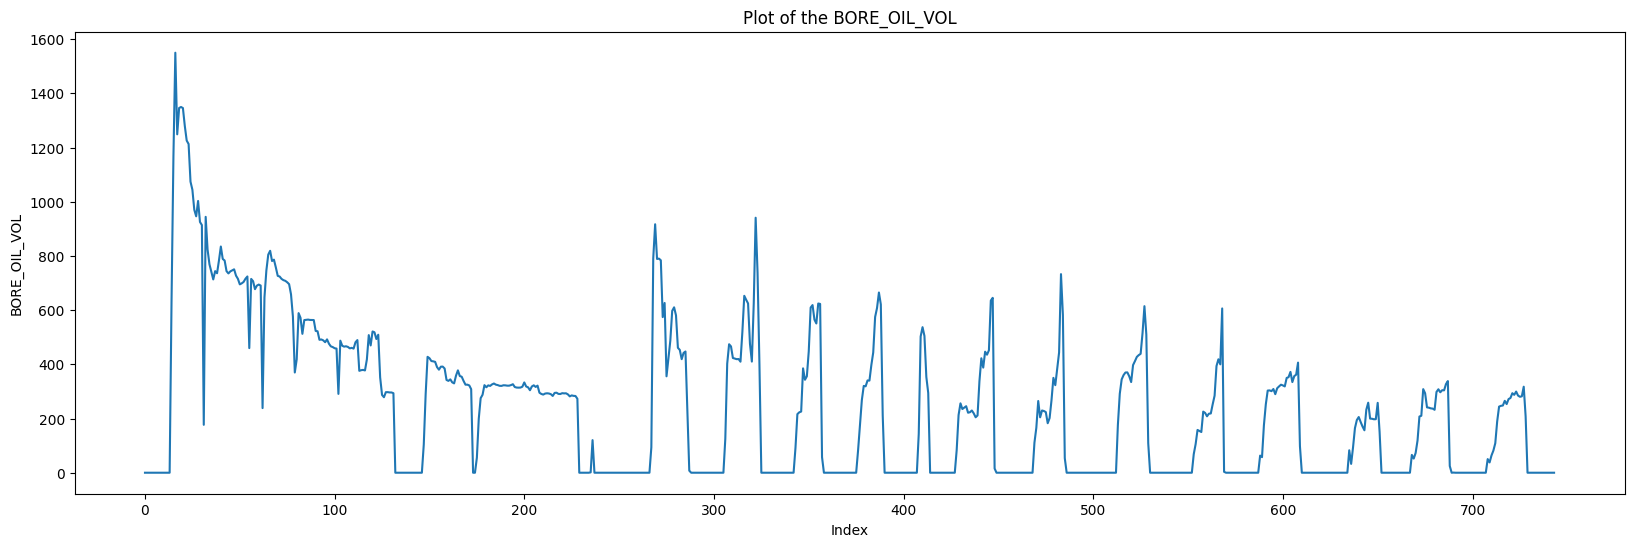

In [10]:
df_filter=df_full[df_full['WELL_TYPE'] != 'WI']
df_filter.isna().sum()
target = df_filter['BORE_OIL_VOL']
print(type(target))
plot_list(target)

## Split Train and Test dataset

In [11]:
train_ratio = 0.8
scaling = "minmax"

# Split the dataset into train and test sets
split_index = int(len(target) * train_ratio)

Train = target[:split_index]
Test = target[split_index:]


In [12]:
print(Train.shape)
print(Test.shape)

(595,)
(149,)


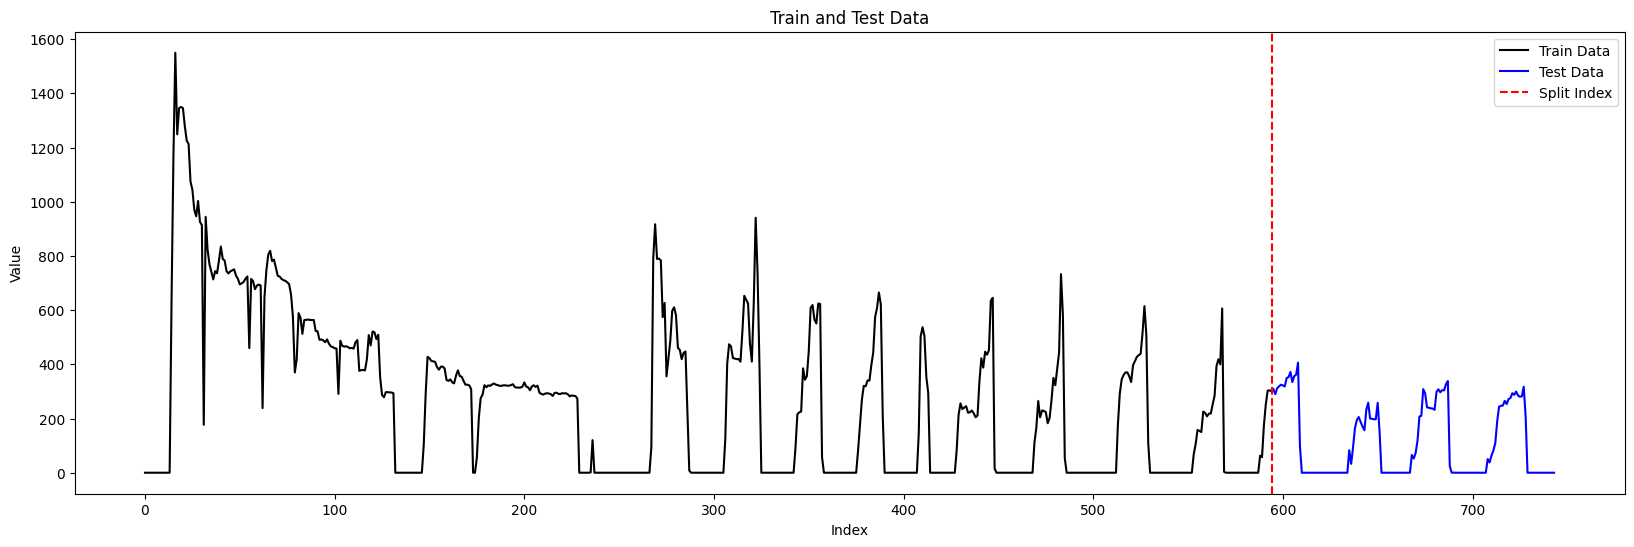

In [13]:
plot_train_test_data(Train, Test, split_index)

## Scaled Data

In [14]:
scaled_train, scaled_test = scale_train_test_data(Train, Test, scaling_type='minmax')
print("Scaled Train Data:", scaled_train[:20])
print()
print("Scaled Test Data:", scaled_test[:20])

Scaled Train Data: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.40744995 0.7526471  1.         0.80571167
 0.8683516  0.87079061]

Scaled Test Data: [0.19930185 0.18703583 0.2011924  0.20558004 0.20958698 0.20788355
 0.20542518 0.22561475 0.2274795  0.24008749 0.21580065 0.23002174
 0.2333899  0.26216762 0.06309806 0.         0.         0.
 0.         0.        ]


## Preparing the X_train, X_test, y_train and y_test

In [15]:
window_size = 14 # Set the sequence length - this is the timeframe used to make a single prediction
num_outputs = 1
X_train, y_train = prepare_rnn_data(scaled_train, window_size, num_outputs)
X_test, y_test = prepare_rnn_data(scaled_test, window_size, num_outputs)

In [16]:
# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
# Prediction Index
print(X_train[window_size][0])
print(y_train[0])

0.40744994547718755
0.0


In [17]:
# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(465, 13) (465,)
(108, 13) (108,)


In [18]:
epochs = 500 # Choose the number of training epochs
batch_size = 1#5#10 # Choose the batch size for training

In [19]:
n_neurons = 50 # X_train.shape[1] * y_train.shape[1]
n_neurons

50

In [20]:
time_steps = window_size - 1  # Subtract 1 because the last element of each window is the label
input_dim = 1 # Since your input data is of shape (744,) i.e., 1-dimensional
output_dim = 1 # Since you want to predict one value for each sequence

# LSTM Model

In [21]:
# pip install optuna
!pip install optuna-integration

In [22]:
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.optimizers import Adam
import pickle

In [23]:
# Define a callback to save information
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, trial):
        self.trial = trial
        self.best_val_loss = float('inf')
        self.best_model = None

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs['val_loss']
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.best_model = self.model
        self.trial.report(val_loss, step=epoch)
        if self.trial.should_prune():
            raise optuna.TrialPruned()

In [24]:
def objective(trial):
    # Define the Optuna search space for hyperparameters
    window_size = trial.suggest_int('window_size', 2, 60)  # Adjust the range as needed
    batch_size = trial.suggest_int('batch_size', 1, 20)  # Adjust the range as needed
    n_lstm_layers = trial.suggest_int('n_lstm_layers', 1, 20)
    lstm_units = trial.suggest_int('lstm_units', 32, 256)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2)
    Dropout_rate = trial.suggest_float('Dropout_rate', 0.1, 0.5)


    # Set the sequence length - this is the timeframe used to make a single prediction
    num_outputs = 1
    X_train, y_train = prepare_rnn_data(scaled_train, window_size, num_outputs)
    X_test, y_test = prepare_rnn_data(scaled_test, window_size, num_outputs)

    time_steps = window_size - 1
    
    # Create the model with the suggested hyperparameters
    model_LSTM = Sequential()
    model_LSTM.reset_states()
    
    for _ in range(n_lstm_layers):
        model_LSTM.add(LSTM(lstm_units, input_shape=(time_steps, input_dim), return_sequences=True))
        model_LSTM.add(Dropout(Dropout_rate))
    
    model_LSTM.add(LSTM(lstm_units, return_sequences=False))
    model_LSTM.add(Dense(output_dim))
    
    # Compile the model with the suggested learning rate
    model_LSTM.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate), metrics=['mean_absolute_error'])

    # Create a custom callback for saving information
    custom_callback = CustomCallback(trial)
    
    # Train the model with your data and use the custom callback
    history = model_LSTM.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[custom_callback], verbose=0)
    
    # Evaluate the model
    val_loss = history.history['val_loss'][-1]
    
    # Save the model as a pkl file
    model_filename = f"model_layer_unit_{trial.number}.pkl"
    with open(model_filename, 'wb') as model_file:
        pickle.dump(model_LSTM, model_file)
    
    return val_loss



In [25]:
# Create an Optuna study
study = optuna.create_study(direction='minimize')



[I 2023-11-03 07:36:25,712] A new study created in memory with name: no-name-b9e0e323-6078-452a-aa64-adffb741e5cd


In [26]:
# Optimize the model using Optuna
study.optimize(objective, n_trials=250)



INFO:tensorflow:Assets written to: ram://29174320-0805-4c30-89e2-aa57ded4c052/assets


[I 2023-11-03 11:47:34,395] Trial 0 finished with value: 0.019677860662341118 and parameters: {'window_size': 45, 'batch_size': 10, 'n_lstm_layers': 19, 'lstm_units': 252, 'learning_rate': 0.00903577464428386, 'Dropout_rate': 0.2395920911749744}. Best is trial 0 with value: 0.019677860662341118.


INFO:tensorflow:Assets written to: ram://7672348c-0367-4ac7-bd08-04408c532164/assets


[I 2023-11-03 12:01:46,876] Trial 1 finished with value: 0.0013206119183450937 and parameters: {'window_size': 17, 'batch_size': 18, 'n_lstm_layers': 3, 'lstm_units': 83, 'learning_rate': 0.0020980221991529005, 'Dropout_rate': 0.10538496338297386}. Best is trial 1 with value: 0.0013206119183450937.


INFO:tensorflow:Assets written to: ram://4143980c-94b0-4571-ab89-864798270620/assets


[I 2023-11-03 13:29:31,282] Trial 2 finished with value: 0.06405678391456604 and parameters: {'window_size': 19, 'batch_size': 5, 'n_lstm_layers': 5, 'lstm_units': 61, 'learning_rate': 0.008676546562993373, 'Dropout_rate': 0.16896246979607293}. Best is trial 1 with value: 0.0013206119183450937.


INFO:tensorflow:Assets written to: ram://1ec571f4-539e-4f9a-ae37-8ebadcd72856/assets


[I 2023-11-03 13:52:19,490] Trial 3 finished with value: 0.02692716009914875 and parameters: {'window_size': 17, 'batch_size': 17, 'n_lstm_layers': 5, 'lstm_units': 122, 'learning_rate': 0.0063712864425546425, 'Dropout_rate': 0.23382822183042218}. Best is trial 1 with value: 0.0013206119183450937.


INFO:tensorflow:Assets written to: ram://2513a439-d88f-47bc-a0a3-c39ad4101871/assets


[I 2023-11-03 15:22:39,519] Trial 4 finished with value: 0.016265636309981346 and parameters: {'window_size': 35, 'batch_size': 13, 'n_lstm_layers': 8, 'lstm_units': 65, 'learning_rate': 0.008945123412880165, 'Dropout_rate': 0.29646322517678386}. Best is trial 1 with value: 0.0013206119183450937.


INFO:tensorflow:Assets written to: ram://09cd8302-1899-4f27-8ef5-f6d06f050e97/assets


[I 2023-11-03 16:28:09,244] Trial 5 finished with value: 0.02418440394103527 and parameters: {'window_size': 50, 'batch_size': 5, 'n_lstm_layers': 1, 'lstm_units': 239, 'learning_rate': 0.002521374297989374, 'Dropout_rate': 0.2862420543199381}. Best is trial 1 with value: 0.0013206119183450937.
[I 2023-11-03 16:29:24,545] Trial 6 pruned. 
[I 2023-11-03 16:30:02,013] Trial 7 pruned. 
[I 2023-11-03 16:54:48,782] Trial 8 pruned. 
[I 2023-11-03 16:55:01,364] Trial 9 pruned. 


INFO:tensorflow:Assets written to: ram://3a50b463-97db-4f37-a4f8-62b14b3964c3/assets


[I 2023-11-03 16:57:53,818] Trial 10 finished with value: 0.0012838649563491344 and parameters: {'window_size': 6, 'batch_size': 19, 'n_lstm_layers': 1, 'lstm_units': 103, 'learning_rate': 0.0004243081615521217, 'Dropout_rate': 0.10321797262437604}. Best is trial 10 with value: 0.0012838649563491344.


INFO:tensorflow:Assets written to: ram://08a2b27b-028c-4429-a9f5-9a72a6b8b5d3/assets


[I 2023-11-03 16:59:19,280] Trial 11 finished with value: 0.001158250728622079 and parameters: {'window_size': 2, 'batch_size': 20, 'n_lstm_layers': 1, 'lstm_units': 106, 'learning_rate': 0.00015313114228922872, 'Dropout_rate': 0.13220579989277154}. Best is trial 11 with value: 0.001158250728622079.


INFO:tensorflow:Assets written to: ram://cfe5a314-b7e4-444c-bf87-d5182c52c5f5/assets


[I 2023-11-03 17:01:45,145] Trial 12 finished with value: 0.001298364601098001 and parameters: {'window_size': 5, 'batch_size': 20, 'n_lstm_layers': 1, 'lstm_units': 109, 'learning_rate': 0.0003345911758193362, 'Dropout_rate': 0.15760218429018055}. Best is trial 11 with value: 0.001158250728622079.


INFO:tensorflow:Assets written to: ram://dc3ee29e-a5f1-4bde-8665-cd4d5cb7f421/assets


[I 2023-11-03 17:06:19,872] Trial 13 finished with value: 0.001168731483630836 and parameters: {'window_size': 2, 'batch_size': 14, 'n_lstm_layers': 6, 'lstm_units': 163, 'learning_rate': 0.0003100927197981549, 'Dropout_rate': 0.16613211012764012}. Best is trial 11 with value: 0.001158250728622079.


INFO:tensorflow:Assets written to: ram://be6cce68-88c1-4d4a-8d4b-13e0af45758d/assets


[I 2023-11-03 17:47:48,400] Trial 14 finished with value: 0.0016832465771585703 and parameters: {'window_size': 2, 'batch_size': 1, 'n_lstm_layers': 6, 'lstm_units': 161, 'learning_rate': 0.0001015505047182427, 'Dropout_rate': 0.3687534457911223}. Best is trial 11 with value: 0.001158250728622079.
[I 2023-11-03 17:48:12,733] Trial 15 pruned. 
[I 2023-11-03 17:48:26,128] Trial 16 pruned. 
[I 2023-11-03 17:48:32,162] Trial 17 pruned. 
[I 2023-11-03 17:48:44,013] Trial 18 pruned. 
[I 2023-11-03 17:48:48,360] Trial 19 pruned. 
[I 2023-11-03 17:49:16,203] Trial 20 pruned. 


INFO:tensorflow:Assets written to: ram://d3c76ad2-3d6d-49c6-928f-a1709f9ac9f4/assets


[I 2023-11-03 17:51:02,737] Trial 21 finished with value: 0.0011615444673225284 and parameters: {'window_size': 3, 'batch_size': 20, 'n_lstm_layers': 1, 'lstm_units': 99, 'learning_rate': 0.00012620450847571408, 'Dropout_rate': 0.10017846409037523}. Best is trial 11 with value: 0.001158250728622079.


INFO:tensorflow:Assets written to: ram://b731db9b-e6f9-4114-8ae8-9a928a781dfe/assets


[I 2023-11-03 17:53:57,399] Trial 22 finished with value: 0.001095189363695681 and parameters: {'window_size': 3, 'batch_size': 20, 'n_lstm_layers': 3, 'lstm_units': 119, 'learning_rate': 0.00032685040928567496, 'Dropout_rate': 0.13694492682495027}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 17:54:01,541] Trial 23 pruned. 
[I 2023-11-03 17:54:07,560] Trial 24 pruned. 
[I 2023-11-03 17:54:13,470] Trial 25 pruned. 
[I 2023-11-03 17:54:16,050] Trial 26 pruned. 
[I 2023-11-03 17:54:20,928] Trial 27 pruned. 
[I 2023-11-03 17:54:31,667] Trial 28 pruned. 
[I 2023-11-03 17:54:42,984] Trial 29 pruned. 
[I 2023-11-03 17:54:46,065] Trial 30 pruned. 


INFO:tensorflow:Assets written to: ram://7cdc08e2-b094-4fd2-83d7-35073e99d4ff/assets


[I 2023-11-03 18:01:25,724] Trial 31 finished with value: 0.001693293103016913 and parameters: {'window_size': 2, 'batch_size': 8, 'n_lstm_layers': 5, 'lstm_units': 179, 'learning_rate': 0.00022154183690800775, 'Dropout_rate': 0.1524204303716364}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 18:01:32,551] Trial 32 pruned. 
[I 2023-11-03 18:01:37,835] Trial 33 pruned. 
[I 2023-11-03 18:01:41,117] Trial 34 pruned. 


INFO:tensorflow:Assets written to: ram://575e7489-13f3-42d3-97d2-cd22481930da/assets


[I 2023-11-03 18:04:23,071] Trial 35 finished with value: 0.00240738014690578 and parameters: {'window_size': 2, 'batch_size': 19, 'n_lstm_layers': 6, 'lstm_units': 171, 'learning_rate': 0.0007737364730015519, 'Dropout_rate': 0.17645841370507875}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 18:04:28,433] Trial 36 pruned. 
[I 2023-11-03 18:04:34,796] Trial 37 pruned. 


INFO:tensorflow:Assets written to: ram://746c0c19-9d8a-457a-8765-9a0a79916f2c/assets


[I 2023-11-03 18:10:48,102] Trial 38 finished with value: 0.001414224854670465 and parameters: {'window_size': 7, 'batch_size': 14, 'n_lstm_layers': 2, 'lstm_units': 133, 'learning_rate': 0.0022397903388011167, 'Dropout_rate': 0.10111458734462783}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 18:11:01,819] Trial 39 pruned. 
[I 2023-11-03 18:12:07,579] Trial 40 pruned. 


INFO:tensorflow:Assets written to: ram://1a0943b6-6ea4-4ade-893f-635d8559b024/assets


[I 2023-11-03 18:14:40,513] Trial 41 finished with value: 0.0015180326299741864 and parameters: {'window_size': 5, 'batch_size': 19, 'n_lstm_layers': 1, 'lstm_units': 100, 'learning_rate': 0.0005570060014715263, 'Dropout_rate': 0.10370741827317013}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 18:14:43,123] Trial 42 pruned. 


INFO:tensorflow:Assets written to: ram://afc1d551-acdd-46c7-ac47-1031f7801edb/assets


[I 2023-11-03 18:17:59,433] Trial 43 finished with value: 0.0014256146969273686 and parameters: {'window_size': 4, 'batch_size': 17, 'n_lstm_layers': 2, 'lstm_units': 87, 'learning_rate': 0.0011703846273084337, 'Dropout_rate': 0.11556519397642068}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 18:18:01,873] Trial 44 pruned. 
[I 2023-11-03 18:18:06,329] Trial 45 pruned. 


INFO:tensorflow:Assets written to: ram://14cfce48-45fd-46f6-b405-ebd6db6a50f0/assets


[I 2023-11-03 18:20:08,357] Trial 46 finished with value: 0.0011858370853587985 and parameters: {'window_size': 2, 'batch_size': 18, 'n_lstm_layers': 2, 'lstm_units': 252, 'learning_rate': 0.0014748642083575354, 'Dropout_rate': 0.13966510645672003}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 18:20:14,176] Trial 47 pruned. 
[I 2023-11-03 18:20:33,996] Trial 48 pruned. 
[I 2023-11-03 18:20:44,266] Trial 49 pruned. 
[I 2023-11-03 18:20:48,110] Trial 50 pruned. 


INFO:tensorflow:Assets written to: ram://3121b82e-5e86-463d-ad01-403456ac96ab/assets


[I 2023-11-03 18:22:56,600] Trial 51 finished with value: 0.0012781958794221282 and parameters: {'window_size': 4, 'batch_size': 20, 'n_lstm_layers': 1, 'lstm_units': 99, 'learning_rate': 0.0006072741206467608, 'Dropout_rate': 0.14279391941536151}. Best is trial 22 with value: 0.001095189363695681.


INFO:tensorflow:Assets written to: ram://ec0d737f-f29c-4f50-b7da-a13dada7b693/assets


[I 2023-11-03 18:25:47,945] Trial 52 finished with value: 0.0014653280377388 and parameters: {'window_size': 4, 'batch_size': 20, 'n_lstm_layers': 2, 'lstm_units': 99, 'learning_rate': 0.000497419380409069, 'Dropout_rate': 0.14907968280400952}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 18:25:50,050] Trial 53 pruned. 
[I 2023-11-03 18:25:53,904] Trial 54 pruned. 
[I 2023-11-03 18:26:04,637] Trial 55 pruned. 
[I 2023-11-03 18:26:10,655] Trial 56 pruned. 


INFO:tensorflow:Assets written to: ram://3e0be0ee-7830-4e8a-ab08-c0bf199b5d59/assets


[I 2023-11-03 18:33:46,864] Trial 57 finished with value: 0.005059347953647375 and parameters: {'window_size': 12, 'batch_size': 12, 'n_lstm_layers': 1, 'lstm_units': 221, 'learning_rate': 0.0013613412221148468, 'Dropout_rate': 0.14263965516543817}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 18:33:51,498] Trial 58 pruned. 
[I 2023-11-03 18:34:00,019] Trial 59 pruned. 
[I 2023-11-03 18:34:46,255] Trial 60 pruned. 


INFO:tensorflow:Assets written to: ram://228e99f4-94f9-444f-b297-ad26a515e3cf/assets


[I 2023-11-03 18:36:59,279] Trial 61 finished with value: 0.0011766664683818817 and parameters: {'window_size': 4, 'batch_size': 19, 'n_lstm_layers': 1, 'lstm_units': 105, 'learning_rate': 0.0009399198890904262, 'Dropout_rate': 0.10056880282360005}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 18:37:03,076] Trial 62 pruned. 
[I 2023-11-03 18:37:04,952] Trial 63 pruned. 
[I 2023-11-03 18:37:07,953] Trial 64 pruned. 
[I 2023-11-03 18:37:12,128] Trial 65 pruned. 
[I 2023-11-03 18:37:17,006] Trial 66 pruned. 
[I 2023-11-03 18:37:19,913] Trial 67 pruned. 
[I 2023-11-03 18:37:23,196] Trial 68 pruned. 


INFO:tensorflow:Assets written to: ram://670815be-10b5-491d-b7cd-9ff22d815f1c/assets


[I 2023-11-03 18:41:55,459] Trial 69 finished with value: 0.003030970226973295 and parameters: {'window_size': 2, 'batch_size': 18, 'n_lstm_layers': 8, 'lstm_units': 156, 'learning_rate': 0.0003758516602260689, 'Dropout_rate': 0.10795610209343638}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 18:41:59,991] Trial 70 pruned. 


INFO:tensorflow:Assets written to: ram://fffb652a-de51-4042-b95c-75d2400163d4/assets


[I 2023-11-03 18:44:07,799] Trial 71 finished with value: 0.001294039306230843 and parameters: {'window_size': 4, 'batch_size': 20, 'n_lstm_layers': 1, 'lstm_units': 105, 'learning_rate': 0.0006848454056493753, 'Dropout_rate': 0.1232915703731837}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 18:44:09,843] Trial 72 pruned. 
[I 2023-11-03 18:44:12,515] Trial 73 pruned. 
[I 2023-11-03 18:44:16,330] Trial 74 pruned. 


INFO:tensorflow:Assets written to: ram://6a322e90-1c76-4954-93b9-4cea1408a356/assets


[I 2023-11-03 18:46:52,264] Trial 75 finished with value: 0.0014985463349148631 and parameters: {'window_size': 2, 'batch_size': 13, 'n_lstm_layers': 2, 'lstm_units': 63, 'learning_rate': 0.0014677315875750918, 'Dropout_rate': 0.1551704724149458}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 18:46:54,916] Trial 76 pruned. 
[I 2023-11-03 18:46:59,168] Trial 77 pruned. 
[I 2023-11-03 18:47:03,310] Trial 78 pruned. 
[I 2023-11-03 18:47:09,624] Trial 79 pruned. 


INFO:tensorflow:Assets written to: ram://04e455bd-d5b1-48b8-8167-3884f33f17bc/assets


[I 2023-11-03 18:53:13,200] Trial 80 finished with value: 0.0015188264660537243 and parameters: {'window_size': 8, 'batch_size': 11, 'n_lstm_layers': 1, 'lstm_units': 151, 'learning_rate': 0.0016959579434315587, 'Dropout_rate': 0.16687808311722357}. Best is trial 22 with value: 0.001095189363695681.


INFO:tensorflow:Assets written to: ram://635eed3e-2749-47a3-95c0-ba4973f8a35e/assets


[I 2023-11-03 18:55:21,130] Trial 81 finished with value: 0.0014373225858435035 and parameters: {'window_size': 4, 'batch_size': 20, 'n_lstm_layers': 1, 'lstm_units': 105, 'learning_rate': 0.0005611706637196125, 'Dropout_rate': 0.1260274104687155}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 18:55:23,059] Trial 82 pruned. 
[I 2023-11-03 18:55:26,857] Trial 83 pruned. 
[I 2023-11-03 18:55:36,799] Trial 84 pruned. 
[I 2023-11-03 18:55:53,353] Trial 85 pruned. 
[I 2023-11-03 18:55:57,354] Trial 86 pruned. 


INFO:tensorflow:Assets written to: ram://1bf6a299-0fa5-4e1b-83f0-3ec7ce36bff4/assets


[I 2023-11-03 18:58:24,748] Trial 87 finished with value: 0.0016013487474992871 and parameters: {'window_size': 5, 'batch_size': 20, 'n_lstm_layers': 1, 'lstm_units': 100, 'learning_rate': 0.0006875724966911884, 'Dropout_rate': 0.12152631717086225}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 18:58:27,071] Trial 88 pruned. 
[I 2023-11-03 18:58:30,447] Trial 89 pruned. 


INFO:tensorflow:Assets written to: ram://be93fc8f-e8c8-4713-98e2-7c980b9d787c/assets


[I 2023-11-03 19:00:43,469] Trial 90 finished with value: 0.0012335525825619698 and parameters: {'window_size': 4, 'batch_size': 19, 'n_lstm_layers': 1, 'lstm_units': 131, 'learning_rate': 0.0009975744209202123, 'Dropout_rate': 0.14697830028656708}. Best is trial 22 with value: 0.001095189363695681.


INFO:tensorflow:Assets written to: ram://6952eb23-1707-4f4f-961a-b08393ee05f4/assets


[I 2023-11-03 19:02:35,510] Trial 91 finished with value: 0.0011837547644972801 and parameters: {'window_size': 3, 'batch_size': 19, 'n_lstm_layers': 1, 'lstm_units': 131, 'learning_rate': 0.0009713397375260556, 'Dropout_rate': 0.17510440445974704}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 19:02:38,684] Trial 92 pruned. 
[I 2023-11-03 19:02:41,045] Trial 93 pruned. 
[I 2023-11-03 19:02:46,718] Trial 94 pruned. 
[I 2023-11-03 19:02:49,251] Trial 95 pruned. 


INFO:tensorflow:Assets written to: ram://630bfe1a-d488-492c-8d84-36a60bbdfc57/assets


[I 2023-11-03 19:04:36,716] Trial 96 finished with value: 0.0011573759838938713 and parameters: {'window_size': 2, 'batch_size': 20, 'n_lstm_layers': 2, 'lstm_units': 214, 'learning_rate': 0.0011116481962612794, 'Dropout_rate': 0.1827367198320241}. Best is trial 22 with value: 0.001095189363695681.


INFO:tensorflow:Assets written to: ram://f5e7d358-65c8-43f5-8a30-dc2059829091/assets


[I 2023-11-03 19:06:25,790] Trial 97 finished with value: 0.0011501818662509322 and parameters: {'window_size': 2, 'batch_size': 20, 'n_lstm_layers': 2, 'lstm_units': 228, 'learning_rate': 0.0011774177068309094, 'Dropout_rate': 0.17836799396387465}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 19:06:53,221] Trial 98 pruned. 


INFO:tensorflow:Assets written to: ram://f8ae9a73-8f9a-4a3a-9809-3516ec96ef18/assets


[I 2023-11-03 19:08:44,796] Trial 99 finished with value: 0.0013735141837969422 and parameters: {'window_size': 2, 'batch_size': 20, 'n_lstm_layers': 2, 'lstm_units': 220, 'learning_rate': 0.0011310639923549472, 'Dropout_rate': 0.1877976493730239}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 19:08:49,092] Trial 100 pruned. 
[I 2023-11-03 19:08:52,891] Trial 101 pruned. 
[I 2023-11-03 19:08:55,767] Trial 102 pruned. 
[I 2023-11-03 19:08:59,814] Trial 103 pruned. 


INFO:tensorflow:Assets written to: ram://cdb48576-6796-4335-bed7-80cfb4e413f7/assets


[I 2023-11-03 19:10:12,195] Trial 104 finished with value: 0.0011636617127805948 and parameters: {'window_size': 2, 'batch_size': 19, 'n_lstm_layers': 1, 'lstm_units': 210, 'learning_rate': 0.0003475225210615298, 'Dropout_rate': 0.14212480488699877}. Best is trial 22 with value: 0.001095189363695681.


INFO:tensorflow:Assets written to: ram://2d9d3a42-a4f6-4333-885e-9fa4c8526579/assets


[I 2023-11-03 19:13:35,506] Trial 105 finished with value: 0.0011108022881671786 and parameters: {'window_size': 2, 'batch_size': 12, 'n_lstm_layers': 3, 'lstm_units': 208, 'learning_rate': 0.0004122007440807209, 'Dropout_rate': 0.1776942413921348}. Best is trial 22 with value: 0.001095189363695681.


INFO:tensorflow:Assets written to: ram://23e564d8-c4f9-4871-8cfe-819985502343/assets


[I 2023-11-03 19:17:34,554] Trial 106 finished with value: 0.0012048614444211125 and parameters: {'window_size': 2, 'batch_size': 10, 'n_lstm_layers': 3, 'lstm_units': 199, 'learning_rate': 0.00035150726743115625, 'Dropout_rate': 0.20222396752528146}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 19:17:38,438] Trial 107 pruned. 


INFO:tensorflow:Assets written to: ram://24d89549-268d-45d0-8acf-73a931861d6a/assets


[I 2023-11-03 19:22:05,179] Trial 108 finished with value: 0.0012131468392908573 and parameters: {'window_size': 2, 'batch_size': 13, 'n_lstm_layers': 5, 'lstm_units': 196, 'learning_rate': 0.00026389145640275547, 'Dropout_rate': 0.1930077742396434}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 19:22:15,025] Trial 109 pruned. 
[I 2023-11-03 19:22:19,122] Trial 110 pruned. 
[I 2023-11-03 19:22:25,014] Trial 111 pruned. 
[I 2023-11-03 19:22:28,014] Trial 112 pruned. 
[I 2023-11-03 19:22:32,266] Trial 113 pruned. 
[I 2023-11-03 19:22:36,455] Trial 114 pruned. 
[I 2023-11-03 19:22:42,269] Trial 115 pruned. 


INFO:tensorflow:Assets written to: ram://0a8cf65f-743b-466a-a21f-8bea04ec5620/assets


[I 2023-11-03 19:28:09,254] Trial 116 finished with value: 0.0013036978198215365 and parameters: {'window_size': 4, 'batch_size': 7, 'n_lstm_layers': 1, 'lstm_units': 250, 'learning_rate': 0.0012139574904880175, 'Dropout_rate': 0.21234926067321874}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 19:28:12,857] Trial 117 pruned. 
[I 2023-11-03 19:28:18,532] Trial 118 pruned. 
[I 2023-11-03 19:28:20,892] Trial 119 pruned. 
[I 2023-11-03 19:28:23,315] Trial 120 pruned. 
[I 2023-11-03 19:28:28,848] Trial 121 pruned. 
[I 2023-11-03 19:28:41,288] Trial 122 pruned. 
[I 2023-11-03 19:28:51,385] Trial 123 pruned. 
[I 2023-11-03 19:28:56,230] Trial 124 pruned. 
[I 2023-11-03 19:29:01,029] Trial 125 pruned. 
[I 2023-11-03 19:29:05,563] Trial 126 pruned. 
[I 2023-11-03 19:29:08,579] Trial 127 pruned. 
[I 2023-11-03 19:29:11,002] Trial 128 pruned. 
[I 2023-11-03 19:29:13,831] Trial 129 pruned. 
[I 2023-11-03 19:29:17,708] Trial 130 pruned. 
[I 2023-11-03 19:29:20,411] Trial 131 pru

INFO:tensorflow:Assets written to: ram://c58f1db0-96d9-4a40-89f2-c9c8ea8d988e/assets


[I 2023-11-03 19:37:32,015] Trial 132 finished with value: 0.0012991962721571326 and parameters: {'window_size': 5, 'batch_size': 4, 'n_lstm_layers': 1, 'lstm_units': 204, 'learning_rate': 0.0004909944078341712, 'Dropout_rate': 0.16640528243243685}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 19:37:36,383] Trial 133 pruned. 
[I 2023-11-03 19:37:40,401] Trial 134 pruned. 
[I 2023-11-03 19:37:42,386] Trial 135 pruned. 
[I 2023-11-03 19:37:45,043] Trial 136 pruned. 
[I 2023-11-03 19:37:47,951] Trial 137 pruned. 
[I 2023-11-03 19:37:50,045] Trial 138 pruned. 
[I 2023-11-03 19:37:53,454] Trial 139 pruned. 
[I 2023-11-03 19:37:55,767] Trial 140 pruned. 
[I 2023-11-03 19:37:57,721] Trial 141 pruned. 


INFO:tensorflow:Assets written to: ram://f35fa65b-22b2-4971-804d-412080fa6b86/assets


[I 2023-11-03 19:39:23,981] Trial 142 finished with value: 0.0011653500841930509 and parameters: {'window_size': 2, 'batch_size': 20, 'n_lstm_layers': 1, 'lstm_units': 98, 'learning_rate': 0.0005637658668761835, 'Dropout_rate': 0.1348040792459386}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 19:39:26,762] Trial 143 pruned. 
[I 2023-11-03 19:39:28,700] Trial 144 pruned. 
[I 2023-11-03 19:39:31,310] Trial 145 pruned. 
[I 2023-11-03 19:39:38,766] Trial 146 pruned. 


INFO:tensorflow:Assets written to: ram://88d2d7a1-326f-4dc3-975d-701e3f01ee58/assets


[I 2023-11-03 19:42:12,971] Trial 147 finished with value: 0.0011797365732491016 and parameters: {'window_size': 5, 'batch_size': 19, 'n_lstm_layers': 1, 'lstm_units': 107, 'learning_rate': 0.0016873978549955281, 'Dropout_rate': 0.18447885315719742}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 19:42:16,019] Trial 148 pruned. 


INFO:tensorflow:Assets written to: ram://f6387e91-9fb3-4e07-8608-8b2dda9cf3d8/assets


[I 2023-11-03 19:44:04,514] Trial 149 finished with value: 0.0012214797316119075 and parameters: {'window_size': 2, 'batch_size': 15, 'n_lstm_layers': 1, 'lstm_units': 103, 'learning_rate': 0.0005789812596442133, 'Dropout_rate': 0.20705603375109743}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 19:44:08,771] Trial 150 pruned. 


INFO:tensorflow:Assets written to: ram://1948928b-cb81-40fa-8b14-271e65d495a5/assets


[I 2023-11-03 19:45:57,571] Trial 151 finished with value: 0.0011652958346530795 and parameters: {'window_size': 2, 'batch_size': 15, 'n_lstm_layers': 1, 'lstm_units': 102, 'learning_rate': 0.0006339142361317766, 'Dropout_rate': 0.20083982694643499}. Best is trial 22 with value: 0.001095189363695681.


INFO:tensorflow:Assets written to: ram://5eba5f76-710b-4d65-b53f-29077ba8f8bd/assets


[I 2023-11-03 19:48:22,780] Trial 152 finished with value: 0.0011842752574011683 and parameters: {'window_size': 2, 'batch_size': 14, 'n_lstm_layers': 2, 'lstm_units': 96, 'learning_rate': 0.00027735052339337225, 'Dropout_rate': 0.19882245194802234}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 19:48:24,871] Trial 153 pruned. 
[I 2023-11-03 19:48:30,044] Trial 154 pruned. 
[I 2023-11-03 19:48:32,749] Trial 155 pruned. 
[I 2023-11-03 19:48:34,844] Trial 156 pruned. 
[I 2023-11-03 19:49:15,544] Trial 157 pruned. 
[I 2023-11-03 19:49:19,280] Trial 158 pruned. 
[I 2023-11-03 19:49:21,531] Trial 159 pruned. 
[I 2023-11-03 19:49:24,266] Trial 160 pruned. 


INFO:tensorflow:Assets written to: ram://98c02be5-3b07-43de-8df6-f0d3d5ac2fef/assets


[I 2023-11-03 19:52:21,664] Trial 161 finished with value: 0.001170366769656539 and parameters: {'window_size': 2, 'batch_size': 14, 'n_lstm_layers': 3, 'lstm_units': 106, 'learning_rate': 0.0002435935019762191, 'Dropout_rate': 0.2011320412321506}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 19:52:25,354] Trial 162 pruned. 
[I 2023-11-03 19:52:27,996] Trial 163 pruned. 


INFO:tensorflow:Assets written to: ram://4efe9f38-bb5b-4b26-977f-22ae7f461692/assets


[I 2023-11-03 19:54:22,201] Trial 164 finished with value: 0.001162527478300035 and parameters: {'window_size': 2, 'batch_size': 14, 'n_lstm_layers': 1, 'lstm_units': 93, 'learning_rate': 0.00042023367778482826, 'Dropout_rate': 0.2013550934729236}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 19:54:24,277] Trial 165 pruned. 
[I 2023-11-03 19:54:26,246] Trial 166 pruned. 
[I 2023-11-03 19:54:28,497] Trial 167 pruned. 
[I 2023-11-03 19:54:31,327] Trial 168 pruned. 
[I 2023-11-03 19:54:33,547] Trial 169 pruned. 
[I 2023-11-03 19:54:36,407] Trial 170 pruned. 
[I 2023-11-03 19:54:39,300] Trial 171 pruned. 
[I 2023-11-03 19:54:41,394] Trial 172 pruned. 


INFO:tensorflow:Assets written to: ram://3246b221-a721-4118-b86f-ef069129dd1e/assets


[I 2023-11-03 19:57:08,836] Trial 173 finished with value: 0.001138239516876638 and parameters: {'window_size': 2, 'batch_size': 14, 'n_lstm_layers': 2, 'lstm_units': 94, 'learning_rate': 0.0006952889991030286, 'Dropout_rate': 0.19616487506531738}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 19:57:17,267] Trial 174 pruned. 
[I 2023-11-03 19:57:19,956] Trial 175 pruned. 


INFO:tensorflow:Assets written to: ram://3b849100-6e73-43d0-88f1-7c535d47ceb7/assets


[I 2023-11-03 19:59:24,844] Trial 176 finished with value: 0.0011528164613991976 and parameters: {'window_size': 2, 'batch_size': 13, 'n_lstm_layers': 1, 'lstm_units': 95, 'learning_rate': 0.0008242479179832373, 'Dropout_rate': 0.1633856161815042}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 19:59:27,035] Trial 177 pruned. 


INFO:tensorflow:Assets written to: ram://57a272bf-c2a5-4823-9d1b-020a4f4bc150/assets


[I 2023-11-03 20:01:21,069] Trial 178 finished with value: 0.0011674395063892007 and parameters: {'window_size': 2, 'batch_size': 14, 'n_lstm_layers': 1, 'lstm_units': 95, 'learning_rate': 0.0004748108216212923, 'Dropout_rate': 0.16340368119442855}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 20:01:23,138] Trial 179 pruned. 
[I 2023-11-03 20:01:25,389] Trial 180 pruned. 
[I 2023-11-03 20:01:27,312] Trial 181 pruned. 
[I 2023-11-03 20:01:30,250] Trial 182 pruned. 


INFO:tensorflow:Assets written to: ram://ddf93dca-cf52-4e37-9b48-8e8b42155c66/assets


[I 2023-11-03 20:03:55,904] Trial 183 finished with value: 0.001148274983279407 and parameters: {'window_size': 2, 'batch_size': 14, 'n_lstm_layers': 2, 'lstm_units': 92, 'learning_rate': 0.0002578149915880864, 'Dropout_rate': 0.2776280980095193}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 20:04:06,641] Trial 184 pruned. 
[I 2023-11-03 20:04:08,939] Trial 185 pruned. 
[I 2023-11-03 20:04:11,049] Trial 186 pruned. 
[I 2023-11-03 20:04:15,066] Trial 187 pruned. 
[I 2023-11-03 20:04:16,973] Trial 188 pruned. 


INFO:tensorflow:Assets written to: ram://f9b728c1-a042-4896-8ff5-ad5e9dd58f9d/assets


[I 2023-11-03 20:06:10,703] Trial 189 finished with value: 0.001150495489127934 and parameters: {'window_size': 2, 'batch_size': 14, 'n_lstm_layers': 1, 'lstm_units': 83, 'learning_rate': 0.0009103031244278728, 'Dropout_rate': 0.14269526196939053}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 20:06:13,339] Trial 190 pruned. 
[I 2023-11-03 20:06:15,340] Trial 191 pruned. 


INFO:tensorflow:Assets written to: ram://78b37a36-8ea3-4a2e-af97-7b58cf59b0da/assets


[I 2023-11-03 20:08:17,824] Trial 192 finished with value: 0.0011560330167412758 and parameters: {'window_size': 2, 'batch_size': 13, 'n_lstm_layers': 1, 'lstm_units': 83, 'learning_rate': 0.0005609866812486888, 'Dropout_rate': 0.12736524631986845}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 20:08:19,795] Trial 193 pruned. 
[I 2023-11-03 20:08:21,921] Trial 194 pruned. 


INFO:tensorflow:Assets written to: ram://01bf24c3-082c-4a29-99a2-080ea301f50a/assets


[I 2023-11-03 20:10:58,083] Trial 195 finished with value: 0.0011239281157031655 and parameters: {'window_size': 2, 'batch_size': 13, 'n_lstm_layers': 2, 'lstm_units': 69, 'learning_rate': 0.0005642980565832602, 'Dropout_rate': 0.1262569793019148}. Best is trial 22 with value: 0.001095189363695681.


INFO:tensorflow:Assets written to: ram://ee515fc1-355c-448c-b852-a5f44c920709/assets


[I 2023-11-03 20:13:43,590] Trial 196 finished with value: 0.001127420924603939 and parameters: {'window_size': 2, 'batch_size': 12, 'n_lstm_layers': 2, 'lstm_units': 68, 'learning_rate': 0.0006252429354638686, 'Dropout_rate': 0.12441810303741811}. Best is trial 22 with value: 0.001095189363695681.


INFO:tensorflow:Assets written to: ram://1e9539be-7fba-4943-bbbd-7840ab5c2253/assets


[I 2023-11-03 20:17:06,560] Trial 197 finished with value: 0.0011360516073182225 and parameters: {'window_size': 2, 'batch_size': 12, 'n_lstm_layers': 3, 'lstm_units': 59, 'learning_rate': 0.0006176468902109548, 'Dropout_rate': 0.14027590432527662}. Best is trial 22 with value: 0.001095189363695681.


INFO:tensorflow:Assets written to: ram://ca7a793d-3d6f-4717-ba5c-de6f31025fed/assets


[I 2023-11-03 20:19:52,729] Trial 198 finished with value: 0.0011359060881659389 and parameters: {'window_size': 2, 'batch_size': 12, 'n_lstm_layers': 2, 'lstm_units': 50, 'learning_rate': 0.000638857987881972, 'Dropout_rate': 0.1247101843215303}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 20:19:56,034] Trial 199 pruned. 
[I 2023-11-03 20:19:58,800] Trial 200 pruned. 


INFO:tensorflow:Assets written to: ram://5fb22ae4-8063-4d93-bf27-465168b699f0/assets


[I 2023-11-03 20:22:44,882] Trial 201 finished with value: 0.0011591686634346843 and parameters: {'window_size': 2, 'batch_size': 12, 'n_lstm_layers': 2, 'lstm_units': 58, 'learning_rate': 0.0005065160869317676, 'Dropout_rate': 0.12046403961303918}. Best is trial 22 with value: 0.001095189363695681.


INFO:tensorflow:Assets written to: ram://15ed4d4d-3180-4d31-831e-c3187aadbbc1/assets


[I 2023-11-03 20:25:31,040] Trial 202 finished with value: 0.001115266582928598 and parameters: {'window_size': 2, 'batch_size': 12, 'n_lstm_layers': 2, 'lstm_units': 45, 'learning_rate': 0.0004891334065068401, 'Dropout_rate': 0.12091086467887102}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 20:25:37,772] Trial 203 pruned. 
[I 2023-11-03 20:25:40,601] Trial 204 pruned. 
[I 2023-11-03 20:25:43,977] Trial 205 pruned. 
[I 2023-11-03 20:25:46,774] Trial 206 pruned. 
[I 2023-11-03 20:25:52,276] Trial 207 pruned. 
[I 2023-11-03 20:25:55,168] Trial 208 pruned. 
[I 2023-11-03 20:25:58,638] Trial 209 pruned. 
[I 2023-11-03 20:26:01,576] Trial 210 pruned. 


INFO:tensorflow:Assets written to: ram://0d0799d8-1812-4b9c-9038-880358148104/assets


[I 2023-11-03 20:28:36,359] Trial 211 finished with value: 0.001135355676524341 and parameters: {'window_size': 2, 'batch_size': 13, 'n_lstm_layers': 2, 'lstm_units': 50, 'learning_rate': 0.0004766328938850255, 'Dropout_rate': 0.13407695969319633}. Best is trial 22 with value: 0.001095189363695681.


INFO:tensorflow:Assets written to: ram://0ea2084c-76ec-49fe-aa6d-cd42a17e1a25/assets


[I 2023-11-03 20:31:22,555] Trial 212 finished with value: 0.0011170725338160992 and parameters: {'window_size': 2, 'batch_size': 12, 'n_lstm_layers': 2, 'lstm_units': 44, 'learning_rate': 0.0004917803769097024, 'Dropout_rate': 0.13689801905637}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 20:31:26,228] Trial 213 pruned. 
[I 2023-11-03 20:31:29,464] Trial 214 pruned. 


INFO:tensorflow:Assets written to: ram://154bbe87-1b64-41a0-9419-59e3af783039/assets


[I 2023-11-03 20:34:04,637] Trial 215 finished with value: 0.0011307871900498867 and parameters: {'window_size': 2, 'batch_size': 13, 'n_lstm_layers': 2, 'lstm_units': 46, 'learning_rate': 0.0006961460431328364, 'Dropout_rate': 0.13181917845158275}. Best is trial 22 with value: 0.001095189363695681.


INFO:tensorflow:Assets written to: ram://7ba1c382-04df-4b4f-bbe3-7fb04d6e5d14/assets


[I 2023-11-03 20:36:51,133] Trial 216 finished with value: 0.0011311142006888986 and parameters: {'window_size': 2, 'batch_size': 12, 'n_lstm_layers': 2, 'lstm_units': 32, 'learning_rate': 0.0010190675988749427, 'Dropout_rate': 0.13205589882046245}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 20:36:54,799] Trial 217 pruned. 
[I 2023-11-03 20:36:57,534] Trial 218 pruned. 
[I 2023-11-03 20:37:01,630] Trial 219 pruned. 
[I 2023-11-03 20:37:04,335] Trial 220 pruned. 


INFO:tensorflow:Assets written to: ram://e7eca939-975f-4704-bda5-9944c5f79d1d/assets


[I 2023-11-03 20:39:39,003] Trial 221 finished with value: 0.001148064504377544 and parameters: {'window_size': 2, 'batch_size': 13, 'n_lstm_layers': 2, 'lstm_units': 46, 'learning_rate': 0.0003398135235865166, 'Dropout_rate': 0.12647407880489495}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 20:39:41,806] Trial 222 pruned. 
[I 2023-11-03 20:39:45,042] Trial 223 pruned. 


INFO:tensorflow:Assets written to: ram://224dba61-0166-4c9f-85f7-2733df37abcc/assets


[I 2023-11-03 20:42:54,814] Trial 224 finished with value: 0.001117047038860619 and parameters: {'window_size': 2, 'batch_size': 13, 'n_lstm_layers': 3, 'lstm_units': 61, 'learning_rate': 0.0005198921624461473, 'Dropout_rate': 0.13421609779317611}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 20:42:58,444] Trial 225 pruned. 
[I 2023-11-03 20:43:02,258] Trial 226 pruned. 
[I 2023-11-03 20:43:12,620] Trial 227 pruned. 
[I 2023-11-03 20:43:16,246] Trial 228 pruned. 
[I 2023-11-03 20:43:19,450] Trial 229 pruned. 
[I 2023-11-03 20:43:22,390] Trial 230 pruned. 
[I 2023-11-03 20:43:25,032] Trial 231 pruned. 


INFO:tensorflow:Assets written to: ram://2b1d6308-701b-4498-86a0-df7624e56575/assets


[I 2023-11-03 20:46:11,373] Trial 232 finished with value: 0.001126261311583221 and parameters: {'window_size': 2, 'batch_size': 12, 'n_lstm_layers': 2, 'lstm_units': 55, 'learning_rate': 0.00039737254064107786, 'Dropout_rate': 0.13507835158036074}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 20:46:15,281] Trial 233 pruned. 
[I 2023-11-03 20:46:17,987] Trial 234 pruned. 
[I 2023-11-03 20:46:21,597] Trial 235 pruned. 


INFO:tensorflow:Assets written to: ram://775e41cd-6b7a-4e86-ba3b-343d338f4dd5/assets


[I 2023-11-03 20:48:59,366] Trial 236 finished with value: 0.0011055481154471636 and parameters: {'window_size': 2, 'batch_size': 13, 'n_lstm_layers': 2, 'lstm_units': 33, 'learning_rate': 0.0007001185129012135, 'Dropout_rate': 0.10707588563958743}. Best is trial 22 with value: 0.001095189363695681.


INFO:tensorflow:Assets written to: ram://275160f4-e12a-468c-a686-d11eb67fec18/assets


[I 2023-11-03 20:51:35,693] Trial 237 finished with value: 0.0011232387041673064 and parameters: {'window_size': 2, 'batch_size': 13, 'n_lstm_layers': 2, 'lstm_units': 32, 'learning_rate': 0.000955161938385689, 'Dropout_rate': 0.12856305603088214}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 20:51:38,597] Trial 238 pruned. 
[I 2023-11-03 20:51:42,566] Trial 239 pruned. 
[I 2023-11-03 20:51:45,770] Trial 240 pruned. 


INFO:tensorflow:Assets written to: ram://46297ad7-b73c-4a0b-84e2-7a304f118e49/assets


[I 2023-11-03 20:54:31,210] Trial 241 finished with value: 0.0011453095357865095 and parameters: {'window_size': 2, 'batch_size': 12, 'n_lstm_layers': 2, 'lstm_units': 42, 'learning_rate': 0.0007245949754475489, 'Dropout_rate': 0.11798837849886673}. Best is trial 22 with value: 0.001095189363695681.


INFO:tensorflow:Assets written to: ram://21fead32-3595-4a4b-8fc4-1c493f15c5f0/assets


[I 2023-11-03 20:57:58,660] Trial 242 finished with value: 0.0011331896530464292 and parameters: {'window_size': 2, 'batch_size': 13, 'n_lstm_layers': 2, 'lstm_units': 39, 'learning_rate': 0.000745152577441055, 'Dropout_rate': 0.11258225352368088}. Best is trial 22 with value: 0.001095189363695681.
[I 2023-11-03 20:58:02,021] Trial 243 pruned. 
[I 2023-11-03 20:58:04,724] Trial 244 pruned. 
[I 2023-11-03 20:58:08,225] Trial 245 pruned. 
[I 2023-11-03 20:58:11,445] Trial 246 pruned. 
[I 2023-11-03 20:58:14,196] Trial 247 pruned. 
[I 2023-11-03 20:58:17,620] Trial 248 pruned. 
[I 2023-11-03 20:58:21,231] Trial 249 pruned. 


In [27]:
# Get the best hyperparameters
best_params = study.best_params
best_loss = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Validation Loss:", best_loss)

Best Hyperparameters: {'window_size': 3, 'batch_size': 20, 'n_lstm_layers': 3, 'lstm_units': 119, 'learning_rate': 0.00032685040928567496, 'Dropout_rate': 0.13694492682495027}
Best Validation Loss: 0.001095189363695681


In [28]:
study.best_params['n_lstm_layers']

3

In [29]:
study.best_trial.number

22

In [30]:
lstm_units = study.best_params['lstm_units']#trial.suggest_int('lstm_units', 32, 256)
learning_rate = study.best_params['learning_rate']#trial.suggest_float('learning_rate', 1e-4, 1e-2)

# Define the Optuna search space for hyperparameters
window_size = study.best_params['window_size']  # Adjust the range as needed
batch_size = study.best_params['batch_size']  # Adjust the range as needed
n_lstm_layers = study.best_params['n_lstm_layers']
lstm_units = study.best_params['lstm_units']
learning_rate = study.best_params['learning_rate']
Dropout_rate = study.best_params['Dropout_rate']


# Set the sequence length - this is the timeframe used to make a single prediction
num_outputs = 1
X_train, y_train = prepare_rnn_data(scaled_train, window_size, num_outputs)
X_test, y_test = prepare_rnn_data(scaled_test, window_size, num_outputs)

time_steps = window_size - 1



best_model_LSTM = Sequential()
best_model_LSTM.reset_states()
    
for _ in range(study.best_params['n_lstm_layers']):
    best_model_LSTM.add(LSTM(lstm_units, input_shape=(time_steps, input_dim), return_sequences=True))
    best_model_LSTM.add(Dropout(Dropout_rate))
    
best_model_LSTM.add(LSTM(lstm_units, return_sequences=False))
best_model_LSTM.add(Dense(output_dim))

# Compile the model with the suggested learning rate
best_model_LSTM.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate), metrics=['mean_absolute_error'])

    
# Train the model with your data and use the custom callback
history = best_model_LSTM.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)
    
# Evaluate the model
train_loss_history_LSTM = history.history['loss']

In [31]:
# Make predictions using the testing data
y_train_pred_LSTM = best_model_LSTM.predict(X_train)
y_test_pred_LSTM = best_model_LSTM.predict(X_test)

4/4 [==============================] - 0s 0s/step


In [32]:
# Calculate Mean Squared Error (MSE)
train_mse_LSTM = mean_squared_error(y_train, y_train_pred_LSTM)
test_mse_LSTM = mean_squared_error(y_test, y_test_pred_LSTM)
print("Train MSE:", train_mse_LSTM)
print("Test MSE:", test_mse_LSTM)

Train MSE: 0.006084559969226588
Test MSE: 0.0015073400102918611


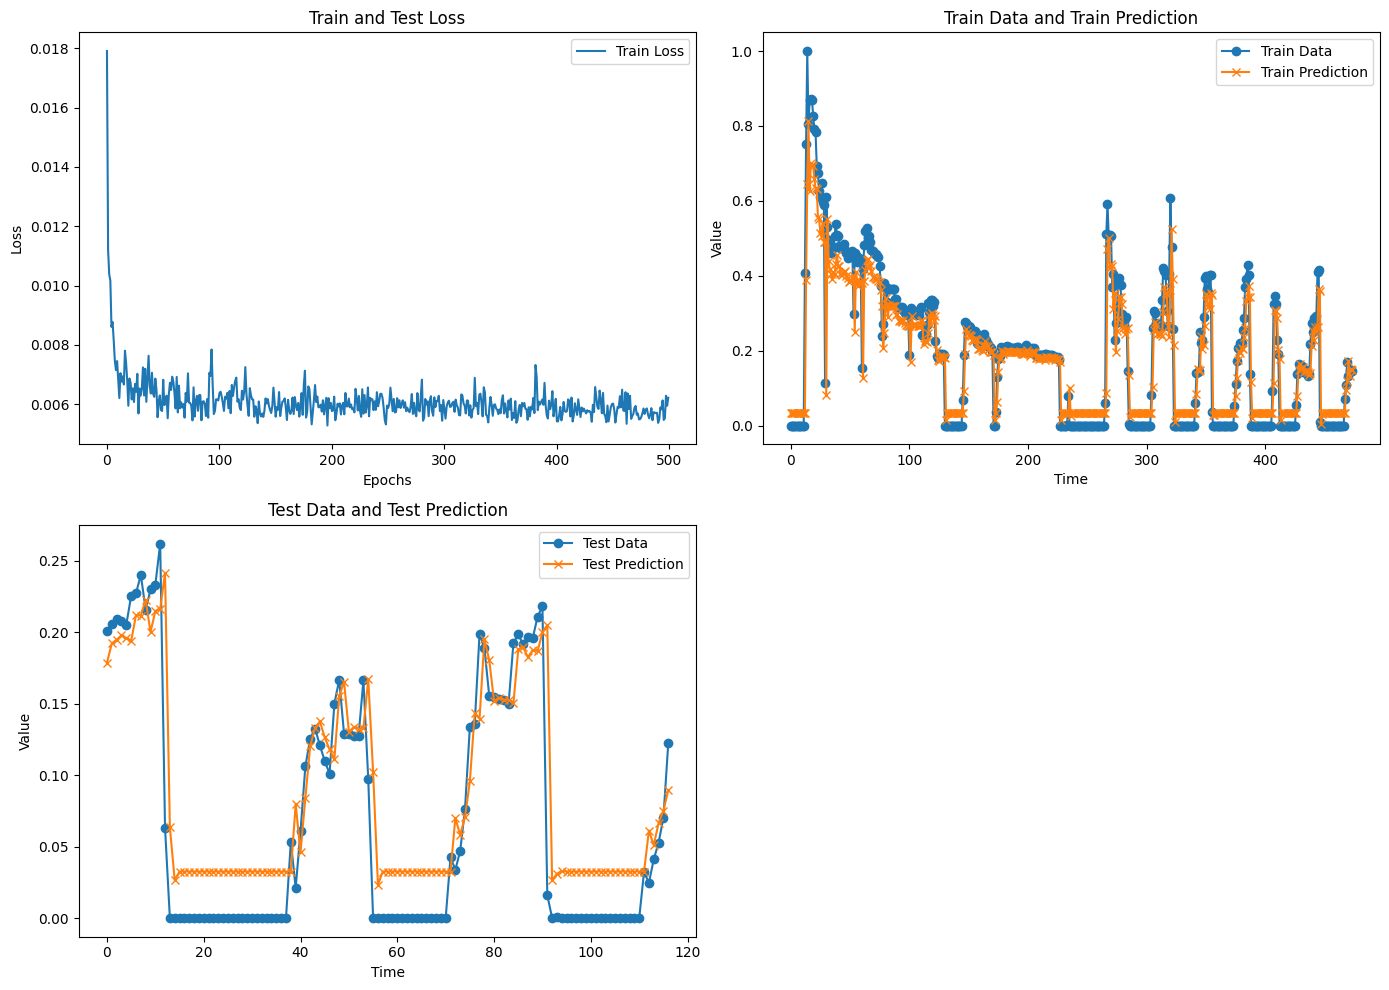

In [33]:
plot_result_graphs(train_loss_history_LSTM, y_train, y_train_pred_LSTM, y_test, y_test_pred_LSTM)

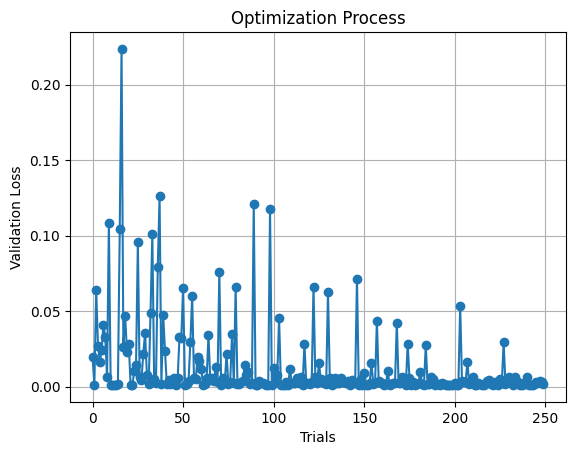

In [34]:
# Extract the validation losses for all trials
val_losses = [trial.value for trial in study.trials]
# Create a plot of validation losses
plt.plot(val_losses, marker='o')
plt.xlabel('Trials')
plt.ylabel('Validation Loss')
plt.title('Optimization Process')
plt.grid(True)
plt.show()

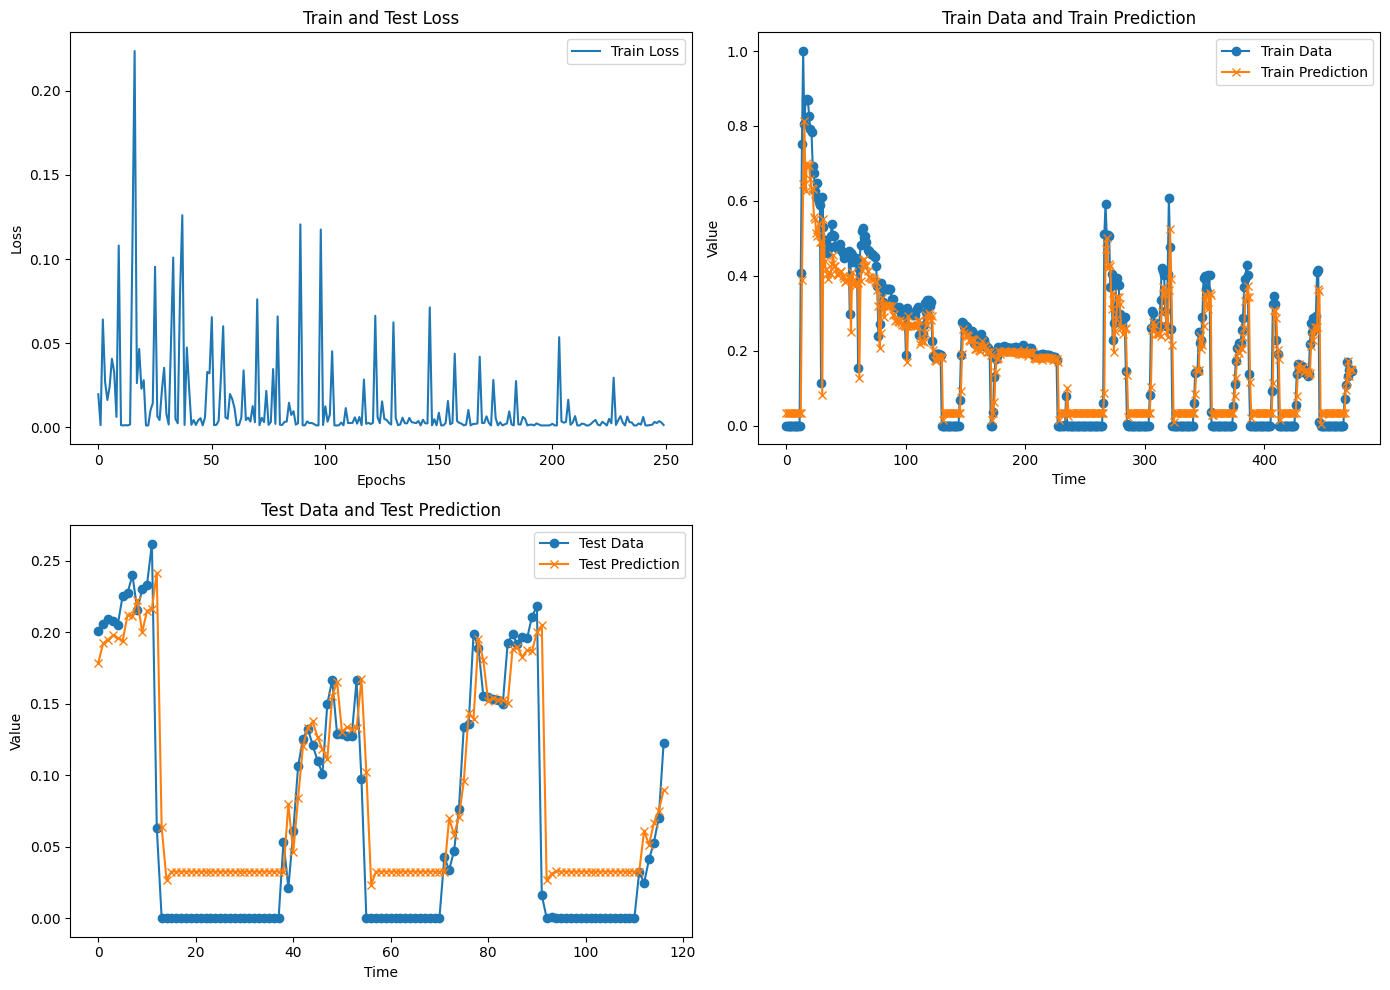

In [35]:
# Plot the graphs
plot_result_graphs(val_losses, y_train, y_train_pred_LSTM, y_test, y_test_pred_LSTM)

### Agora vamos criar o modelo com a melhor solução

In [36]:
# model_LSTM = Sequential()
# model_LSTM.reset_states()
# # model_LSTM.add(LSTM(n_neurons, input_shape=(time_steps, input_dim)))
# model_LSTM.add(LSTM(n_neurons, input_shape=(time_steps, input_dim), return_sequences=True))
# # model_LSTM.add(Dropout(0.2))  # Add dropout with a certain rate (e.g., 20%)
# model_LSTM.add(LSTM(n_neurons, return_sequences=True))
# model_LSTM.add(Dropout(0.2))  # Add dropout with a certain rate (e.g., 20%)
# model_LSTM.add(LSTM(n_neurons, return_sequences=True))
# model_LSTM.add(LSTM(n_neurons, return_sequences=False))
# model_LSTM.add(Dense(output_dim))
# model_LSTM.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

In [37]:
# # Train the model
# history_LSTM = model_LSTM.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)
# train_loss_history_LSTM = history_LSTM.history['loss']

In [38]:
# # Make predictions using the testing data
# y_train_pred_LSTM = model_LSTM.predict(X_train)
# y_test_pred_LSTM = model_LSTM.predict(X_test)

In [39]:
# # Calculate Mean Squared Error (MSE)
# train_mse_LSTM = mean_squared_error(y_train, y_train_pred_LSTM)
# test_mse_LSTM = mean_squared_error(y_test, y_test_pred_LSTM)
# print("Train MSE:", train_mse_LSTM)
# print("Test MSE:", test_mse_LSTM)

In [40]:
# # Plot the graphs
# plot_result_graphs(train_loss_history_LSTM, y_train, y_train_pred_LSTM, y_test, y_test_pred_LSTM)

## Plot dos modelos

In [41]:
# from keras.utils.vis_utils import plot_model


In [42]:
# plot_model(model_LSTM)

In [43]:
class GroundTruthPreviousValue:
    def generate_data(self, input_data):
        num_samples = len(input_data)
        output_data = np.zeros(num_samples)

        for i in range(1, num_samples):
            output_data[i] = input_data[i - 1]

        return output_data

In [44]:
ground_truth_model_previous_value = GroundTruthPreviousValue()
# Generate the ground truth data using the previous value approach for both training and test datasets
ground_truth_data_train_previous_value = ground_truth_model_previous_value.generate_data(y_train)
ground_truth_data_test_previous_value = ground_truth_model_previous_value.generate_data(y_test)

In [45]:
# Calculate MSE for GroundTruthPreviousValue
mse_train_previous_value = mean_squared_error(ground_truth_data_train_previous_value, y_train)
mse_test_previous_value = mean_squared_error(ground_truth_data_test_previous_value, y_test)

print("Ground Truth Previous Value:")
print(f"Train MSE: {mse_train_previous_value}")
print(f"Test MSE: {mse_test_previous_value}")

Ground Truth Previous Value:
Train MSE: 0.005384506264685233
Test MSE: 0.0014857349715086416


In [46]:
import pandas as pd

def compare_rmse(lstm_train_rmse, lstm_test_rmse, baseline_train_rmse, baseline_test_rmse):
    """
    Compare the MSE of train and test data for different models.

    Parameters:
        rnn_train_rmse (float): MSE of the RNN model on the train data.
        rnn_test_rmse (float): MSE of the RNN model on the test data.
        gru_train_rmse (float): MSE of the GRU model on the train data.
        gru_test_rmse (float): MSE of the GRU model on the test data.
        lstm_train_rmse (float): MSE of the LSTM model on the train data.
        lstm_test_rmse (float): MSE of the LSTM model on the test data.
        baseline_train_rmse (float): MSE of the Baseline model on the train data.
        baseline_test_rmse (float): MSE of the Baseline model on the test data.

    Returns:
        pandas.DataFrame: A table containing the comparison of MSE values for different models.
    """
    model_names = [ 'LSTM', 'Baseline']
    train_mse_values = [lstm_train_rmse, baseline_train_rmse]
    test_mse_values = [ lstm_test_rmse, baseline_test_rmse]

    comparison_df = pd.DataFrame({'Model': model_names,
                                  'Train MSE': train_mse_values,
                                  'Test MSE': test_mse_values})

    return comparison_df

In [47]:
comparison_table = compare_rmse(train_mse_LSTM, test_mse_LSTM, mse_train_previous_value, mse_test_previous_value)
print(comparison_table)

      Model  Train MSE  Test MSE
0      LSTM   0.006085  0.001507
1  Baseline   0.005385  0.001486


In [48]:
# Get the list of suggested hyperparameters for all trials
suggested_hyperparameters = [trial.params for trial in study.trials]

In [49]:
# You can access the suggested hyperparameters for all trials using suggested_hyperparameters
print("Suggested Hyperparameters for All Trials:")
for i, params in enumerate(suggested_hyperparameters):
    print(f"Trial {i + 1}: {params}")

Suggested Hyperparameters for All Trials:
Trial 1: {'window_size': 45, 'batch_size': 10, 'n_lstm_layers': 19, 'lstm_units': 252, 'learning_rate': 0.00903577464428386, 'Dropout_rate': 0.2395920911749744}
Trial 2: {'window_size': 17, 'batch_size': 18, 'n_lstm_layers': 3, 'lstm_units': 83, 'learning_rate': 0.0020980221991529005, 'Dropout_rate': 0.10538496338297386}
Trial 3: {'window_size': 19, 'batch_size': 5, 'n_lstm_layers': 5, 'lstm_units': 61, 'learning_rate': 0.008676546562993373, 'Dropout_rate': 0.16896246979607293}
Trial 4: {'window_size': 17, 'batch_size': 17, 'n_lstm_layers': 5, 'lstm_units': 122, 'learning_rate': 0.0063712864425546425, 'Dropout_rate': 0.23382822183042218}
Trial 5: {'window_size': 35, 'batch_size': 13, 'n_lstm_layers': 8, 'lstm_units': 65, 'learning_rate': 0.008945123412880165, 'Dropout_rate': 0.29646322517678386}
Trial 6: {'window_size': 50, 'batch_size': 5, 'n_lstm_layers': 1, 'lstm_units': 239, 'learning_rate': 0.002521374297989374, 'Dropout_rate': 0.286242054